<a href="https://colab.research.google.com/github/CMDRZero/DataScienceFundamentalsClass/blob/main/GranBellU5Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 19.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [4]:
import arviz as az
import pymc as pm     #The engine of prediction
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
import preliz as pz   #We are using this so I can make the nice graphs of priors and likelyhoods
import urllib.request #Using advice from stack exchange

# Predicting age of death using year of death

Okay, so I've got this giant database of ages that people die at and I know life expectancy has increased in the last centuries, so I suspect there might be an upward trend it can learn.

I'll fetch and evaluate the raw file I handled seperately below.

In [ ]:
url = 'https://raw.githubusercontent.com/CMDRZero/DataScienceFundamentalsClass/refs/heads/main/U5-ages.txt'
data = eval(urllib.request.urlopen(url).read())

Preprocessing code was this
```
import csv
with open('ages.csv',encoding = 'utf-8') as file:
    reader = csv.reader(file)
    data = list(reader)
ID = 0
NAME = 1
DESCRPTION = 2
GENDER = 3
COUNTRY = 4
JOB = 5
BIRTHYEAR = 6
DEATHYEAR = 7
DEATHMANNER = 8
AGE = 9

table = []

for row in data[1:]:
    if row[DEATHYEAR] == '' or row[AGE] == '':
        continue
    
    table.append((
        int(row[DEATHYEAR]),
        int(row[AGE]),
        ))

with open('U5-ages.txt', 'w',encoding = 'utf-8') as f:
    f.write(repr(table))
```

Now I just need to shorten it to make the code run in a manageable time frame, as well as swap the axis so its death year to predict age, not the otherway around.

Also Note I am using YEAR OF DEATH, not YEAR OF BIRTH. This is to prevent a very strong correlation between people born in 2000 and dying at age 24. Hmmmm I wonder why that could be (Almost like this is a data set of dead people).

Using year of death controls for this while still hopefully getting most of the same trends

In [ ]:
import random
random.shuffle(data)
yearages = np.transpose(np.array(data[:1_000_000]))

In [ ]:
frame = pd.DataFrame({'Death Year':yearages[0], 'Age':yearages[1]})  #Put it into a frame for usage later
frame

,Death Year,Age
0,2015,95
1,1552,33
2,1954,67
3,2017,75
4,1774,63
...,...,...
999995,1888,68
999996,1859,40
999997,1866,60
999998,1959,87


Lets plot it to see if theres anything meaningfull.

<Axes: xlabel='Death Year', ylabel='Age'>

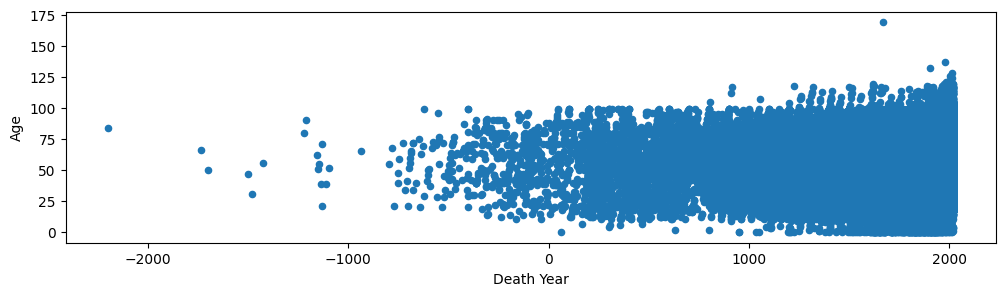

In [ ]:
frame.plot(x="Death Year", y="Age", figsize=(12, 3), kind="scatter")

We can also very clearly see some data problems, those vertical lines of points look like people dying on documented days but having an unknown birth year, thus meaning age of death looks like the last two digits of the year

Ok... Weierd, it mostly just widens out. But we also see a large influx of very young deaths. This is probably a dataset problem, as people who died very young along time ago likely werent recorded. We do however see a large increase in people who live like above 90. Yet we also see some anomolously high points for long life claimants which might skew data.

So huh, no real trendline, maybe if I convert the data using standard deviations to percentiles?

In [ ]:
import scipy.stats
mean = np.mean(yearages[1])
std = np.std(yearages[1])
mean, std

(69.283545, 16.622902551389)

In [ ]:
py = scipy.stats.norm(mean, std).cdf(yearages[1]) #Using a normal distribution computer percentiles from the information we having using its total mean and stdev.

In [ ]:
frame = pd.DataFrame({'Death Year':yearages[0], 'Age':yearages[1], 'Prob': py})  #Put it into a frame for usage later
frame

,Death Year,Age,Prob
0,2015,95,0.939074
1,1552,33,0.014527
2,1954,67,0.445368
3,2017,75,0.634536
4,1774,63,0.352713
...,...,...,...
999995,1888,68,0.469226
999996,1859,40,0.039065
999997,1866,60,0.288259
999998,1959,87,0.856740


And lets plot it now

<Axes: xlabel='Death Year', ylabel='Prob'>

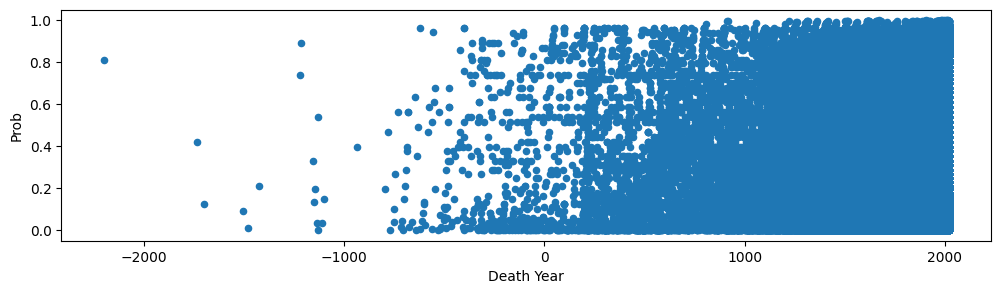

In [ ]:
frame[:1_000_000].plot(x="Death Year", y="Prob", figsize=(12, 3), kind="scatter")

Yeahhhh, ok thats not good. I suspect this actually made it worse, but I was hoping this nonlinear transformation might extract some general trend, instead it seems like the influx in data recently dragged down its mean meaning it just gets flooded with equal points and old ones are random.

Ok, this is probably not fixable, new data go!

# Predicting Golf Official Career Earnings using Putting Average

Lets try and predict how well people earn, but given how well they play.

Theres a phrase in golf which is that putting is half the game, which is basically to say that having a long drive is great and all, but most of your score comes from converting birdies (two green strokes) and not bogeying (4+ strokes).

We expect that a low putting average will mean a higher earning, and to start I'll assume the relationship is linear (I suspect its polynomial or even hyper exponential)

In [8]:
golf_data = pd.read_csv('https://raw.githubusercontent.com/CMDRZero/DataScienceFundamentalsClass/refs/heads/main/golfdata.csv')
golf_data

,Rank,Player,Avg,Birdie Conversion,Money
0,1,Scottie Scheffler,1.680,36.81%,29228357
1,2,Sam Burns,1.685,37.35%,6185830
2,3,Wyndham Clark,1.694,36.85%,10901416
3,4,Collin Morikawa,1.704,35.31%,8383572
4,4,Taylor Pendrith,1.704,35.78%,4797854
...,...,...,...,...,...
80,170,Will Zalatoris,1.803,27.52%,4569320
81,176,Kevin Kisner,1.807,27.44%,175278
82,177,Camilo Villegas,1.809,27.79%,232296
83,180,Ryan Palmer,1.814,28.36%,163716


<Axes: xlabel='Avg', ylabel='Money'>

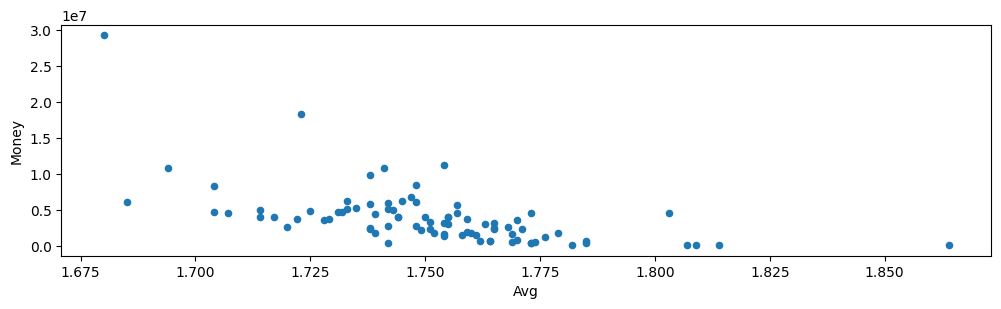

In [9]:
golf_data.plot(x="Avg", y="Money", figsize=(12, 3), kind="scatter")

Hmmm, ok, this isnt quite as linear as I was suspecting. I guess this happens, because everywhere I looked where money is distributed off of some metric for skill, high skill tends to be associated with a wide variation in pay. I'll try and use a linear model here (it looks awefully linear), but I'll have to give it weak priors as theres not an abvious trend.

In [10]:
import math

In [11]:
scale = 1_000_000
golf_data["Money"] = golf_data["Money"] / scale

I've decided to scale down all of the numbers by 1 million dollars because this makes the numbers much easier to read and I suspect the predictor will like smaller numbers better

I'm also gonna guess at the slope and bias as being about 10/(.125) = 80, and 80 * 1.8 = 144 ~= 150

# Model #1 Norm(Lin, H.Norm)

Lets go with the simplest model to start. I'll use those guesses at slope and bias and give them a generous standard deviation at one third mu. This should let it correct me if I was very wrong, but also shouldn't make it take too long.

<Axes: >

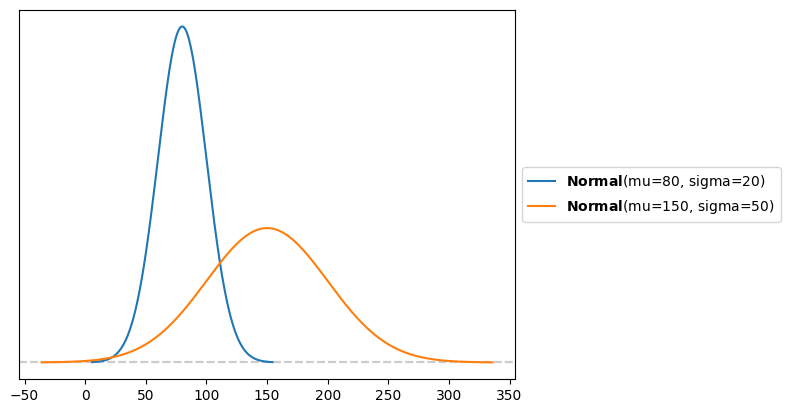

In [7]:
pz.Normal(80, 20).plot_pdf()
pz.Normal(150, 50).plot_pdf()

I've choosen to use normal distrubutions since I dont think a fancy prior for my linear relationships parameters will do me any good, so start simple.

I've choosen to model the likelyhood as a normal distribution to start with as this should let it get a general guess and then sort of fuzz it with uncertainty since salary is variable. Since I've choosen another normal I'll model its standard deviation as a half normal with an abritrary sigma of 1 since that just means I've got about the range [0, 3] which should probably encompass any variance.

In [ ]:
with pm.Model() as model_lg:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=80, sigma=20)
    β = pm.Normal("β", mu=150, sigma=50) #Eyeballed value

    #this is the linear part of our model
    μ = pm.Deterministic("μ", -α * golf_data.Avg + β)
    μ2 = pm.HalfNormal("μ2", sigma=1)

    #likelihood
    y = pm.Normal("y", mu=μ, sigma=μ2, observed=golf_data.Money)

    #inference data object
    idata_lg = pm.sample()

Output()

Output()

In [ ]:
#model_lg.debug()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>],
      dtype=object)

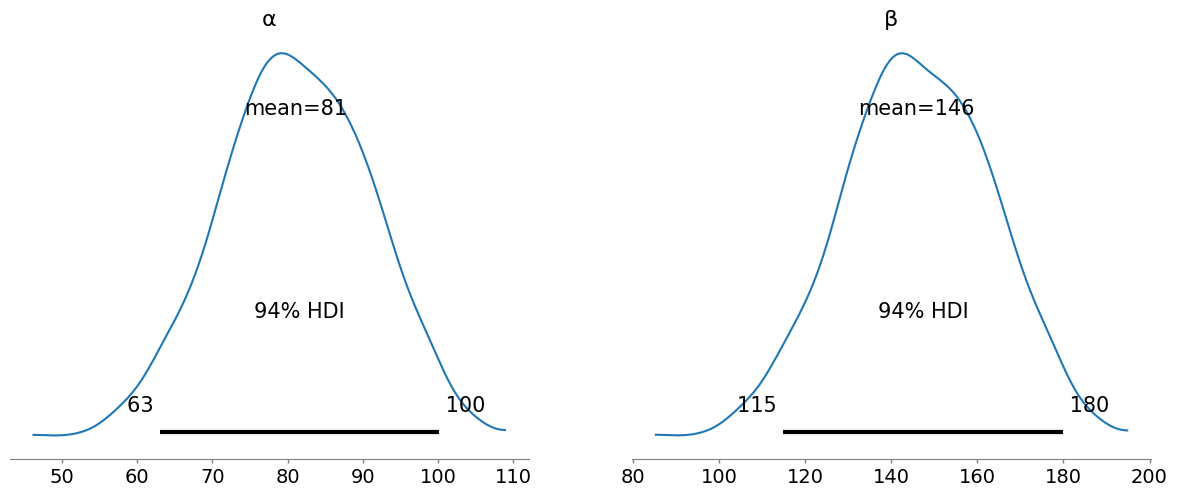

In [ ]:
az.plot_posterior(idata_lg, var_names=["~μ","~μ2"])

Ok, this is good, I was pretty close with my guess for slope and bias, with a slope of 81 instead of 80, and 146 instead of my mathed 144 which I rounded to 150.

Text(0, 0.5, 'Career Earnings')

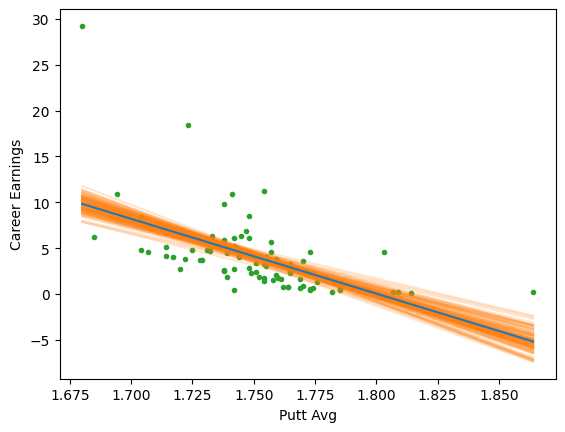

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_lg, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(golf_data.Avg.min(), golf_data.Avg.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = -posterior["α"].mean() * x_plot + posterior["β"].mean()

#These are a 50 lines that our model came up with
lines = -posterior["α"] * x_plot + posterior["β"]

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(golf_data.Avg, golf_data.Money, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Putt Avg")
ax.set_ylabel("Career Earnings")

Just looking at this model I see it does fine enough, but I feel like I can give it some more variation as skill increases to account for the outliers. Since I write all of these justifications in retrospect, I know that this didnt work and thats because I missunderstood what I was changing. I was changing the sigma for my likelyhood, not my priors, so this did nothing other than change my PPC which I wasnt visualizing yet.

# Model #2 Norm(Lin, Lin)

I decided to try and change the variation to also depend on skill, with a high skill (lower score) having a high value and being scaled by some parameter k I'll let the computer figure out.

In [12]:
with pm.Model() as model_lg_2:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=80, sigma=20)
    β = pm.Normal("β", mu=150, sigma=50) #Eyeballed value

    k = pm.HalfNormal("k", sigma=3)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", -α * golf_data.Avg + β)
    μ2 = pm.Deterministic("μ2", k * np.exp(2 - μ))    #I wierdly used mu here, Idk why,
          #I know originally it was based on pay, but then I forgot and gave it the wrong code

    #likelihood
    y = pm.Normal("y", mu=μ, sigma=μ2, observed=golf_data.Money)

    #inference data object
    idata_lg_2 = pm.sample()

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7df6024e7a30>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so: cannot open shared object file: No such file or directory
Exception ignored on calling ctypes callback function: <function ThreadpoolCon

Output()

Output()

array([<Axes: title={'center': 'k'}>, <Axes: title={'center': 'α'}>,
       <Axes: title={'center': 'β'}>], dtype=object)

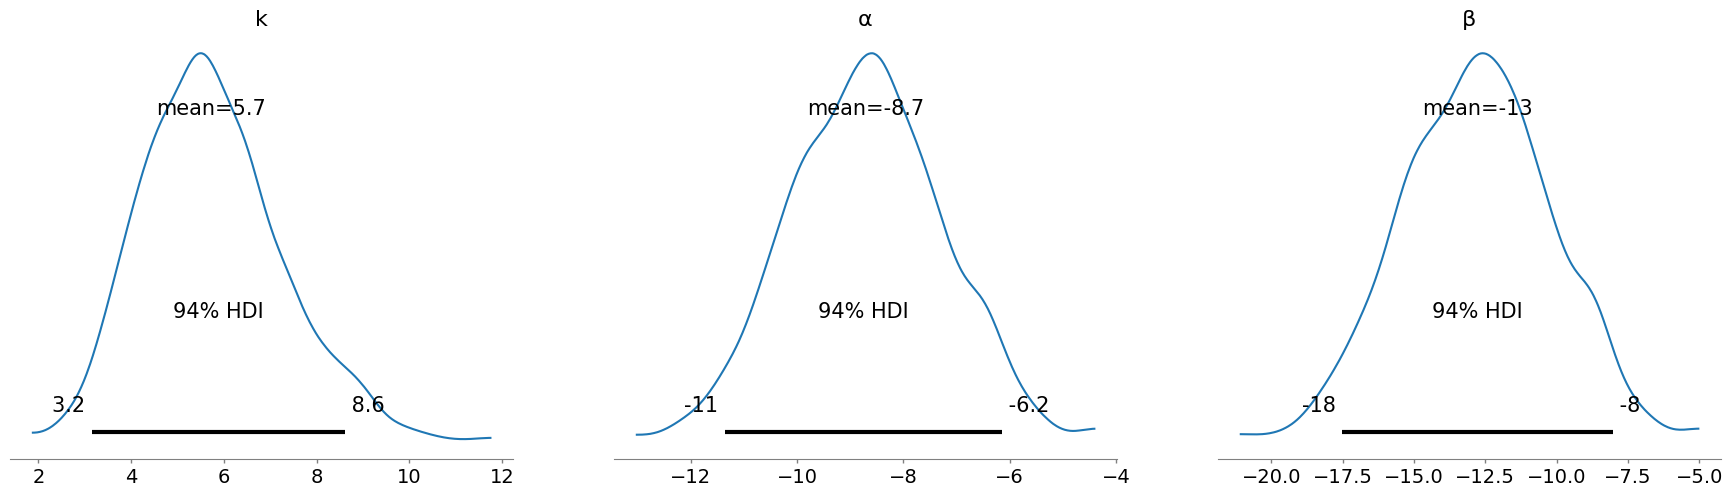

In [13]:
az.plot_posterior(idata_lg_2, var_names=["~μ","~μ2"])

Okay... my slopes went negative. Thats a bad sign

Text(0, 0.5, 'Career Earnings')

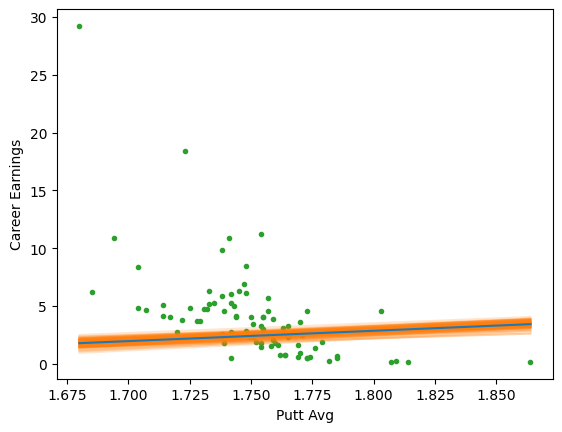

In [14]:
#grabs 100 posterior samples
posterior = az.extract(idata_lg_2, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(golf_data.Avg.min(), golf_data.Avg.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = -posterior["α"].mean() * x_plot + posterior["β"].mean()

#These are a 50 lines that our model came up with
lines = -posterior["α"] * x_plot + posterior["β"]

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(golf_data.Avg, golf_data.Money, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Putt Avg")
ax.set_ylabel("Career Earnings")

Okay, so I cannot say why, but this destroyed the linear prediction, now its not grounded in reality at all and I dont really know why.

My only last thing I'll do is plot the PPC even tho I didnt do that originally.

Output()

<Axes: xlabel='y'>

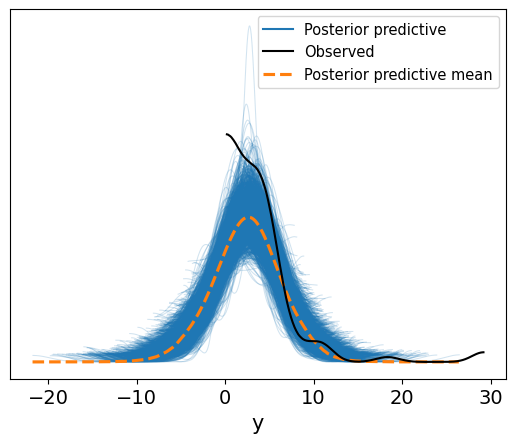

In [17]:
pm.sample_posterior_predictive(idata_lg_2, model = model_lg_2, extend_inferencedata=True)
pm.plot_ppc(idata_lg_2)

We'll actually see, but this seems better than my other linear prediction, I suspect it had to sacrifice the line to make the slope fit, but somehow its decent

# Model #3 Norm(Lin, H.Norm) + PPC

I went back to my first model and just amped up the variation (k.sigma) in hopes that would work better than hard coding it as a linear relationship. This didnt really do much and we got a near identicle model to our first.

In [ ]:
with pm.Model() as model_lg_3:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=80, sigma=20)
    β = pm.Normal("β", mu=150, sigma=50) #Eyeballed value

    k = pm.HalfNormal("k", sigma=3)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", -α * golf_data.Avg + β)
    μ2 = pm.Deterministic("μ2", k)

    #likelihood
    y = pm.Normal("y", mu=μ, sigma=μ2, observed=golf_data.Money)

    #inference data object
    idata_lg_3 = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'k'}>, <Axes: title={'center': 'α'}>,
       <Axes: title={'center': 'β'}>], dtype=object)

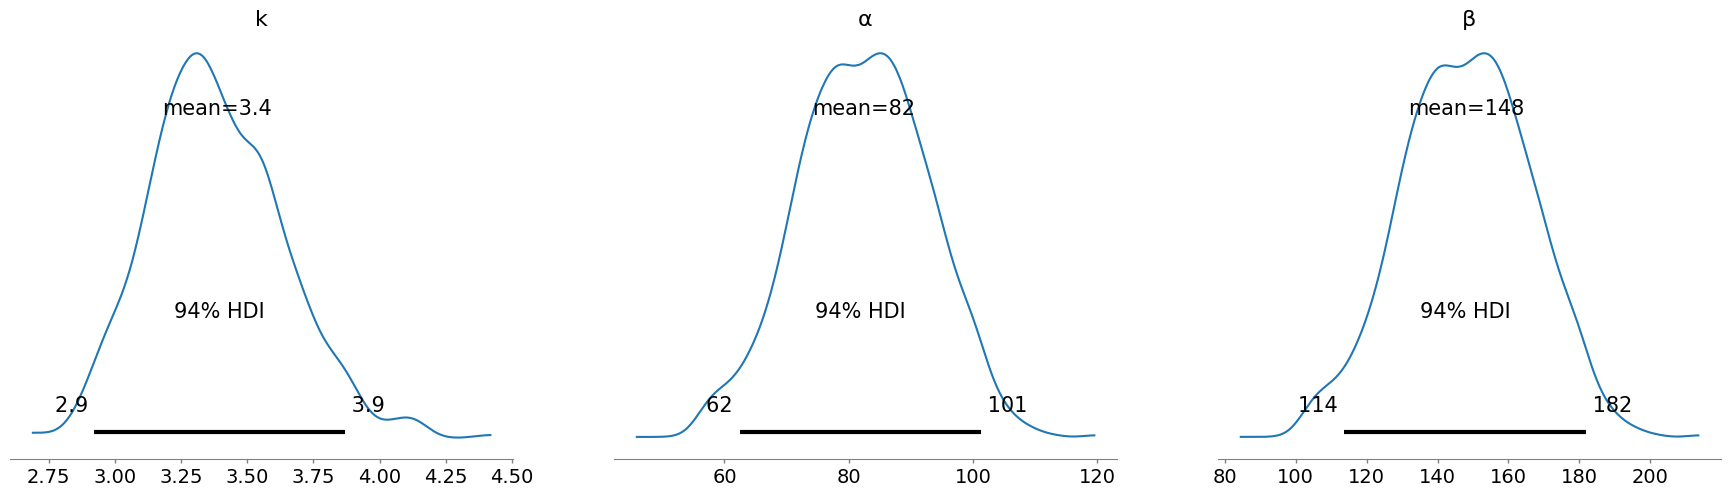

In [ ]:
az.plot_posterior(idata_lg_3, var_names=["~μ","~μ2"])

Text(0, 0.5, 'Career Earnings')

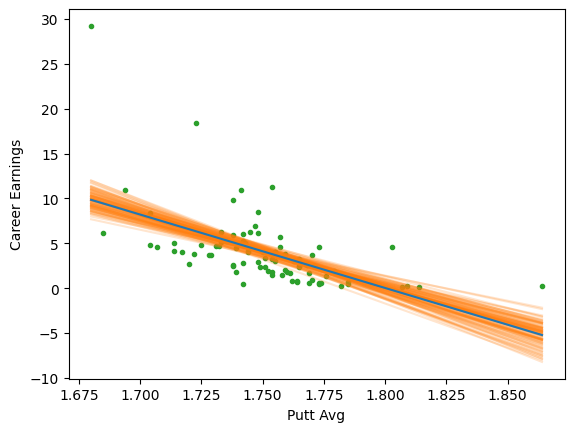

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_lg_3, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(golf_data.Avg.min(), golf_data.Avg.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = -posterior["α"].mean() * x_plot + posterior["β"].mean()

#These are a 50 lines that our model came up with
lines = -posterior["α"] * x_plot + posterior["β"]

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(golf_data.Avg, golf_data.Money, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Putt Avg")
ax.set_ylabel("Career Earnings")

In [ ]:
pm.sample_posterior_predictive(idata_lg_3, model = model_lg_3, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

This time I actually plot the PPC since I wanted to know if the line being good would predict well.

<Axes: xlabel='y'>

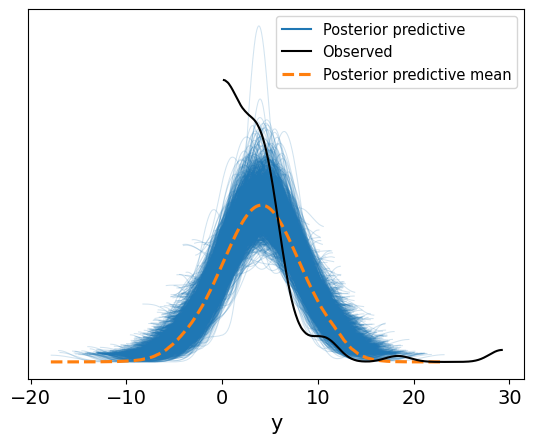

In [ ]:
pm.plot_ppc(idata_lg_3)

Ok, it did not. I realized that my assumption that it looks like normal distribution around a mean from a trendline obiously didnt work. We see the likelyhoods shape dominating the curve which actually looks rather exponential. I'll try changing my likelyhood next then.

# Model #4 Exp(Lin) + PPC

I changed my likelhood from Normal to Exponential and dropped the variance term

In [ ]:
with pm.Model() as model_lg_4:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=80, sigma=20)
    β = pm.Normal("β", mu=150, sigma=50) #Eyeballed value

    k = pm.HalfNormal("k", sigma=3)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", -α * golf_data.Avg + β)
    μ2 = pm.Deterministic("μ2", k)

    #likelihood
    y = pm.Exponential("y", scale=μ, observed=golf_data.Money)

    #inference data object
    idata_lg_4 = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 750 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Eek, 750 divergences isnt great. It didnt take down the program, but those tend to make your graphs look funky. Maybe my assumptions about mean dont work well anymore, but I'll just have to see.

Output()

<Axes: xlabel='y'>

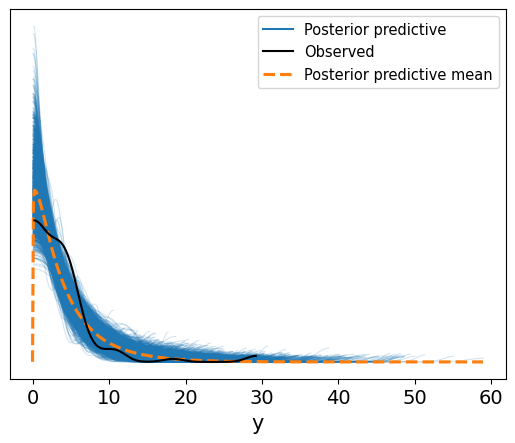

In [ ]:
pm.sample_posterior_predictive(idata_lg_4, model = model_lg_4, extend_inferencedata=True)
pm.plot_ppc(idata_lg_4)

Eyyyyy! This works pretty well it seems, thats a much better fit than what I had before. I dont know why it was diverging because this looks quite good.

array([<Axes: title={'center': 'k'}>, <Axes: title={'center': 'α'}>,
       <Axes: title={'center': 'β'}>], dtype=object)

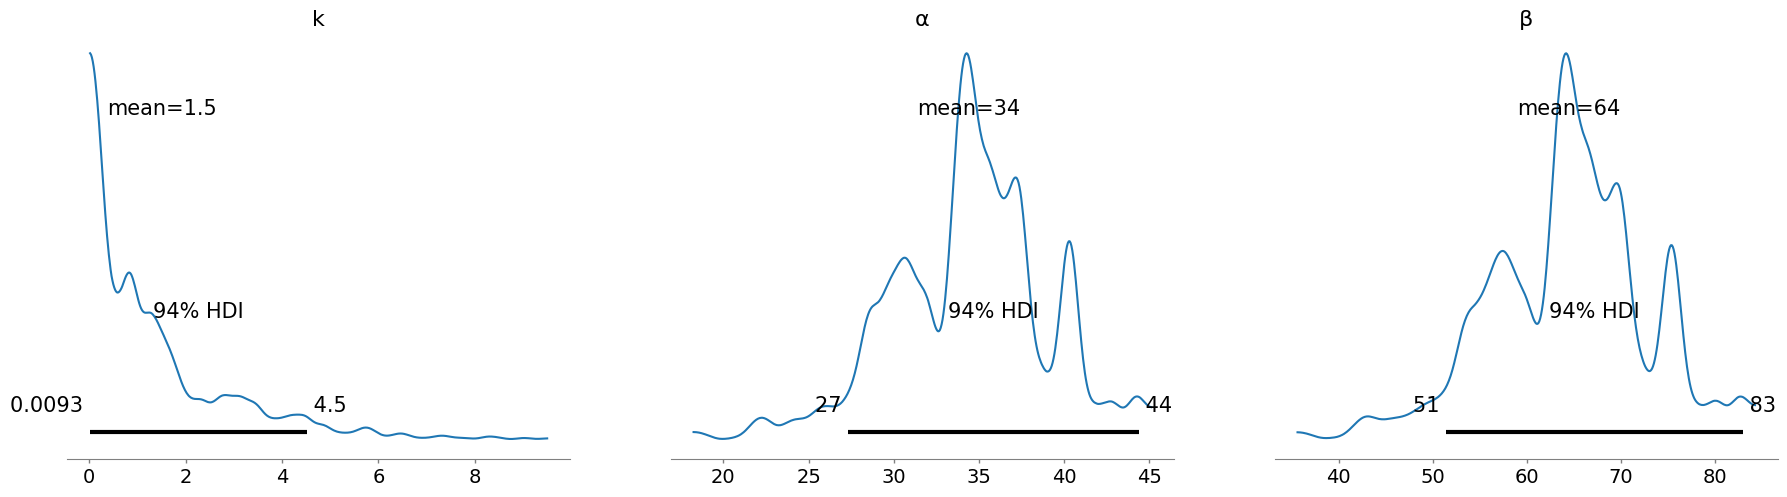

In [ ]:
az.plot_posterior(idata_lg_4, var_names=["~μ","~μ2"])

Okay WTH is going on here, k isnt even used and I forgot to delete it, so its just going awol doing nothing, and alpha and beta are super bumpy and wya off from what I remeber them being. This is probably those divergences.

Text(0, 0.5, 'Career Earnings')

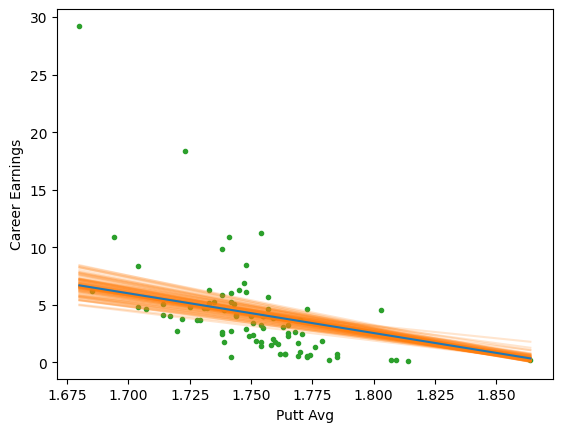

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_lg_4, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(golf_data.Avg.min(), golf_data.Avg.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = -posterior["α"].mean() * x_plot + posterior["β"].mean()

#These are a 50 lines that our model came up with
lines = -posterior["α"] * x_plot + posterior["β"]

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(golf_data.Avg, golf_data.Money, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Putt Avg")
ax.set_ylabel("Career Earnings")

Well, actually that looks fine, I can see its now aiming higher, probably since not all of the exponentially sampled variables will get that far. Maybe I should have used something like a Gamma or Weibullt hat has a mode at nonzero and an area around that with a left skew or long right tail.

# Model #5 Exp(Lin) + PPC - Random Variables

Here I just cleaned up the random variables, nsprisingly it did very little if anything

In [ ]:
with pm.Model() as model_lg_5:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=80, sigma=20)
    β = pm.Normal("β", mu=150, sigma=50) #Eyeballed value

    #this is the linear part of our model
    μ = pm.Deterministic("μ", -α * golf_data.Avg + β)

    #likelihood
    y = pm.Exponential("y", scale=μ, observed=golf_data.Money)

    #inference data object
    idata_lg_5 = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 620 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['μ2'] have not been found and will be ignored
  warnings.warn(


array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>],
      dtype=object)

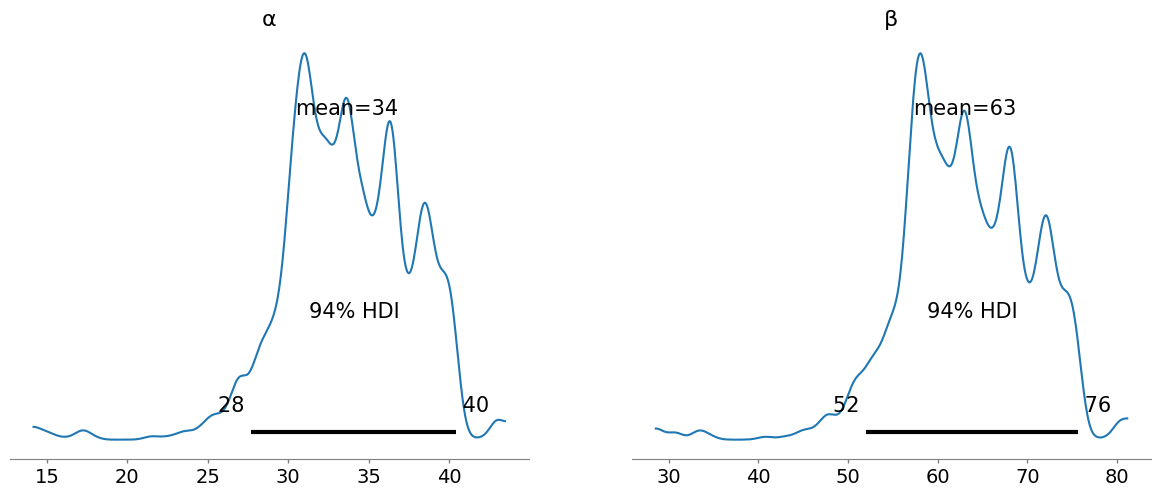

In [ ]:
az.plot_posterior(idata_lg_5, var_names=["~μ"])

Text(0, 0.5, 'Career Earnings')

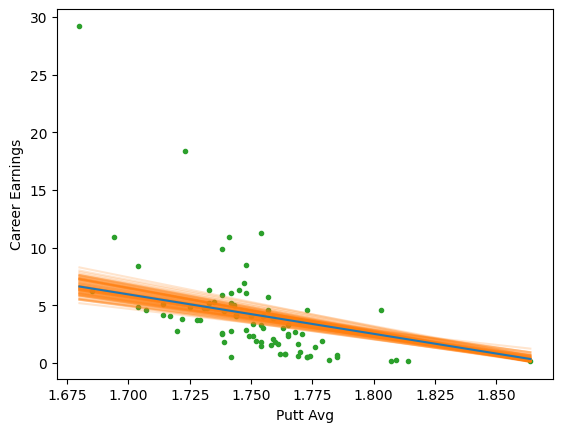

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_lg_5, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(golf_data.Avg.min(), golf_data.Avg.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = -posterior["α"].mean() * x_plot + posterior["β"].mean()

#These are a 50 lines that our model came up with
lines = -posterior["α"] * x_plot + posterior["β"]

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(golf_data.Avg, golf_data.Money, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Putt Avg")
ax.set_ylabel("Career Earnings")

# Model #6 Norm(Lin, .1)

This was a stupid idea where I just asked it to hardcode the variuation on the normal curve from earlier to be a very tight .1, trying to force it to come up with the best linear curve.

In [ ]:
with pm.Model() as model_lg_6:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=80, sigma=20)
    β = pm.Normal("β", mu=150, sigma=50) #Eyeballed value

    #k = pm.HalfNormal("k", sigma=.01)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", -α * golf_data.Avg + β)
    #μ2 = pm.Deterministic("μ2", k)

    #likelihood
    y = pm.Normal("y", mu=μ, sigma=.1, observed=golf_data.Money)

    #inference data object
    idata_lg_6 = pm.sample()

Output()

Output()

Text(0, 0.5, 'Career Earnings')

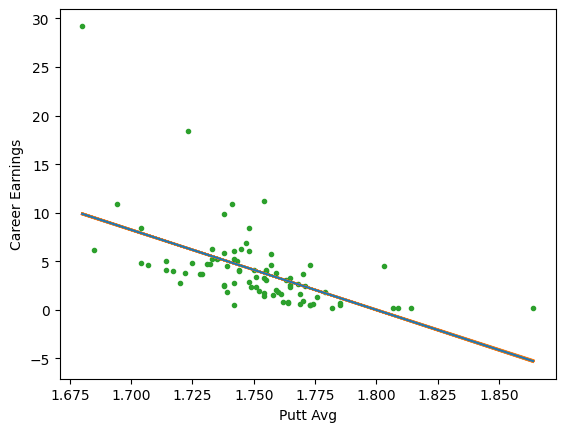

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_lg_6, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(golf_data.Avg.min(), golf_data.Avg.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = -posterior["α"].mean() * x_plot + posterior["β"].mean()

#These are a 50 lines that our model came up with
lines = -posterior["α"] * x_plot + posterior["β"]

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(golf_data.Avg, golf_data.Money, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Putt Avg")
ax.set_ylabel("Career Earnings")

Output()

<Axes: xlabel='y'>

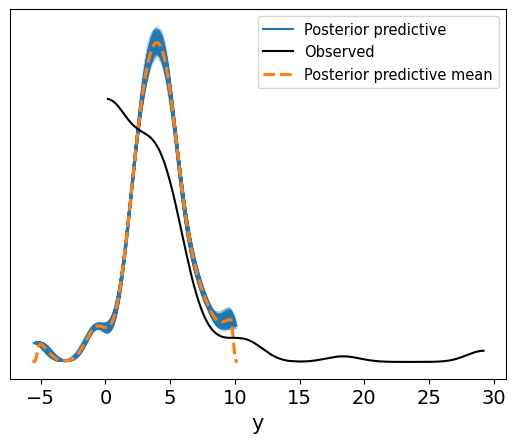

In [ ]:
pm.sample_posterior_predictive(idata_lg_6, model = model_lg_6, extend_inferencedata=True)
pm.plot_ppc(idata_lg_6)

Actually, rather suprisingly this isnt the absolute worst, which suggests to me that my choice in likelyhood was probably poor, or that giving it a single universally sampled prior for standard deviation was a bad idea. The second model I now realize I coded wrong but it might be able to do well.

# Model #7 Gamma(lin, H.Norm)

The final model I've made as of now, this time I used again a tighter prior for my shape parameter but scale is just a linear relation to the skill.

In [ ]:
with pm.Model() as model_lg_7:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=80, sigma=20)
    β = pm.Normal("β", mu=150, sigma=50) #Eyeballed value

    k = pm.HalfNormal("k", sigma=1)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", -α * golf_data.Avg + β)

    #likelihood
    y = pm.Gamma("y", mu=μ, sigma=k, observed=golf_data.Money)

    #inference data object
    idata_lg_7 = pm.sample(target_accept=0.98)

Output()

Output()

ERROR:pymc.stats.convergence:There were 108 divergences after tuning. Increase `target_accept` or reparameterize.


Tis originally threw alot of divergences, but going off of prior models it seems like thats nit actually messing with the result, so I just increased target_accept.

Output()

<Axes: xlabel='y'>

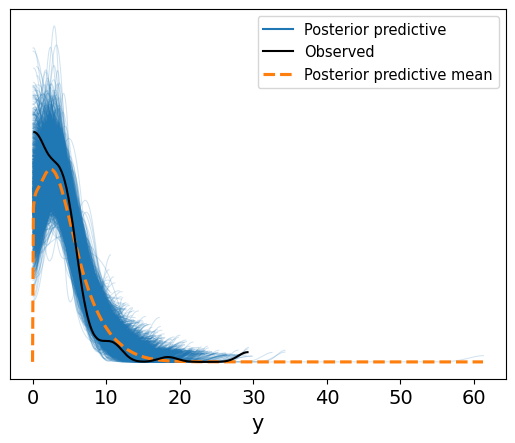

In [ ]:
pm.sample_posterior_predictive(idata_lg_7, model = model_lg_7, extend_inferencedata=True)
pm.plot_ppc(idata_lg_7)

This is looking vry good, a bit like the exponential but a bit rounded off.

Text(0, 0.5, 'Career Earnings')

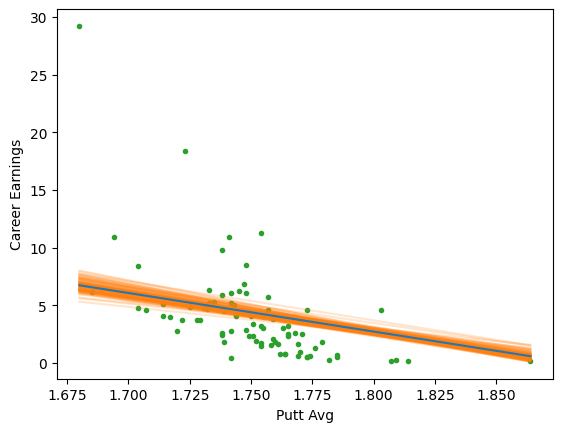

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_lg_7, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(golf_data.Avg.min(), golf_data.Avg.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = -posterior["α"].mean() * x_plot + posterior["β"].mean()

#These are a 50 lines that our model came up with
lines = -posterior["α"] * x_plot + posterior["β"]

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(golf_data.Avg, golf_data.Money, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Putt Avg")
ax.set_ylabel("Career Earnings")

The line seems to again sort of overshoot the data, but thats acdeptle because it feels like it learning the general trend which is important.

array([<Axes: title={'center': 'k'}>, <Axes: title={'center': 'α'}>,
       <Axes: title={'center': 'β'}>], dtype=object)

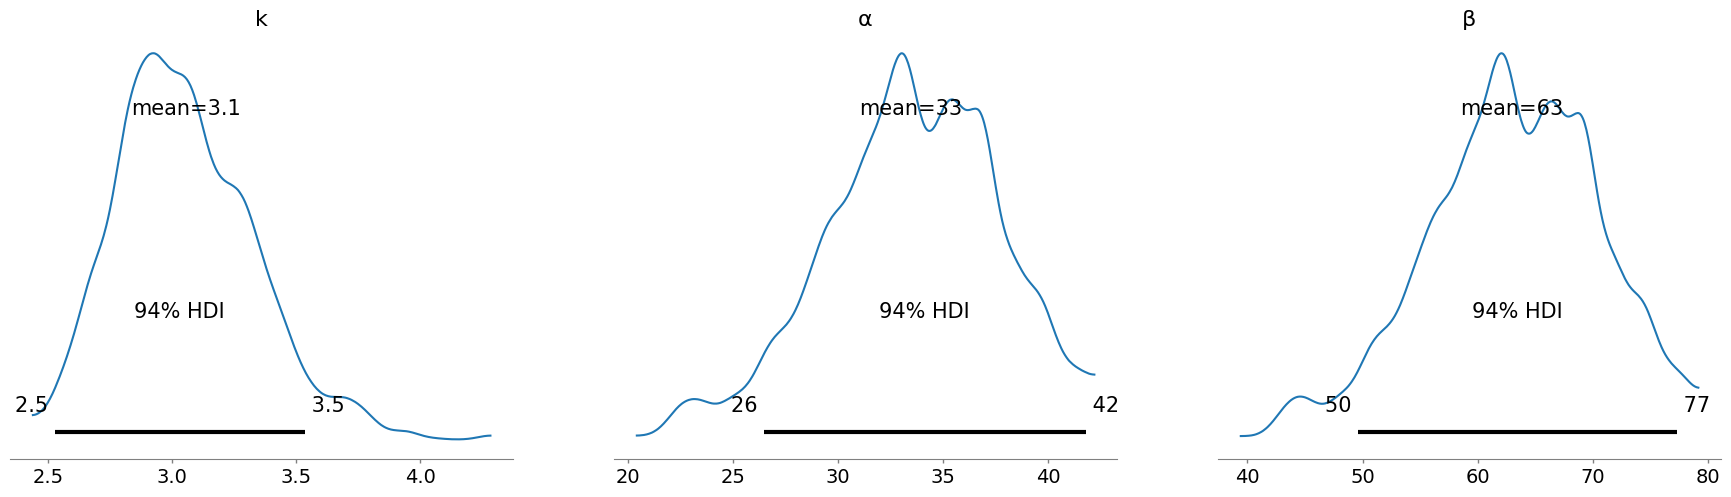

In [ ]:
az.plot_posterior(idata_lg_7, var_names=["~μ"])